# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random
from os import listdir

# Set random seeds for reproducibility
random.seed(42)          # Python's random module
np.random.seed(42)       # NumPy (used by scikit-learn)
tf.random.set_seed(42)   # TensorFlow/Keras

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

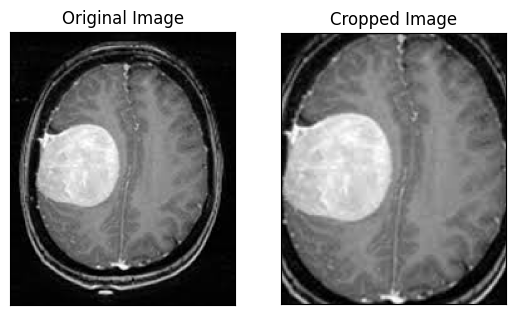

In [3]:
ex_img = cv2.imread('../../yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [5]:
augmented_path = '../../augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [6]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

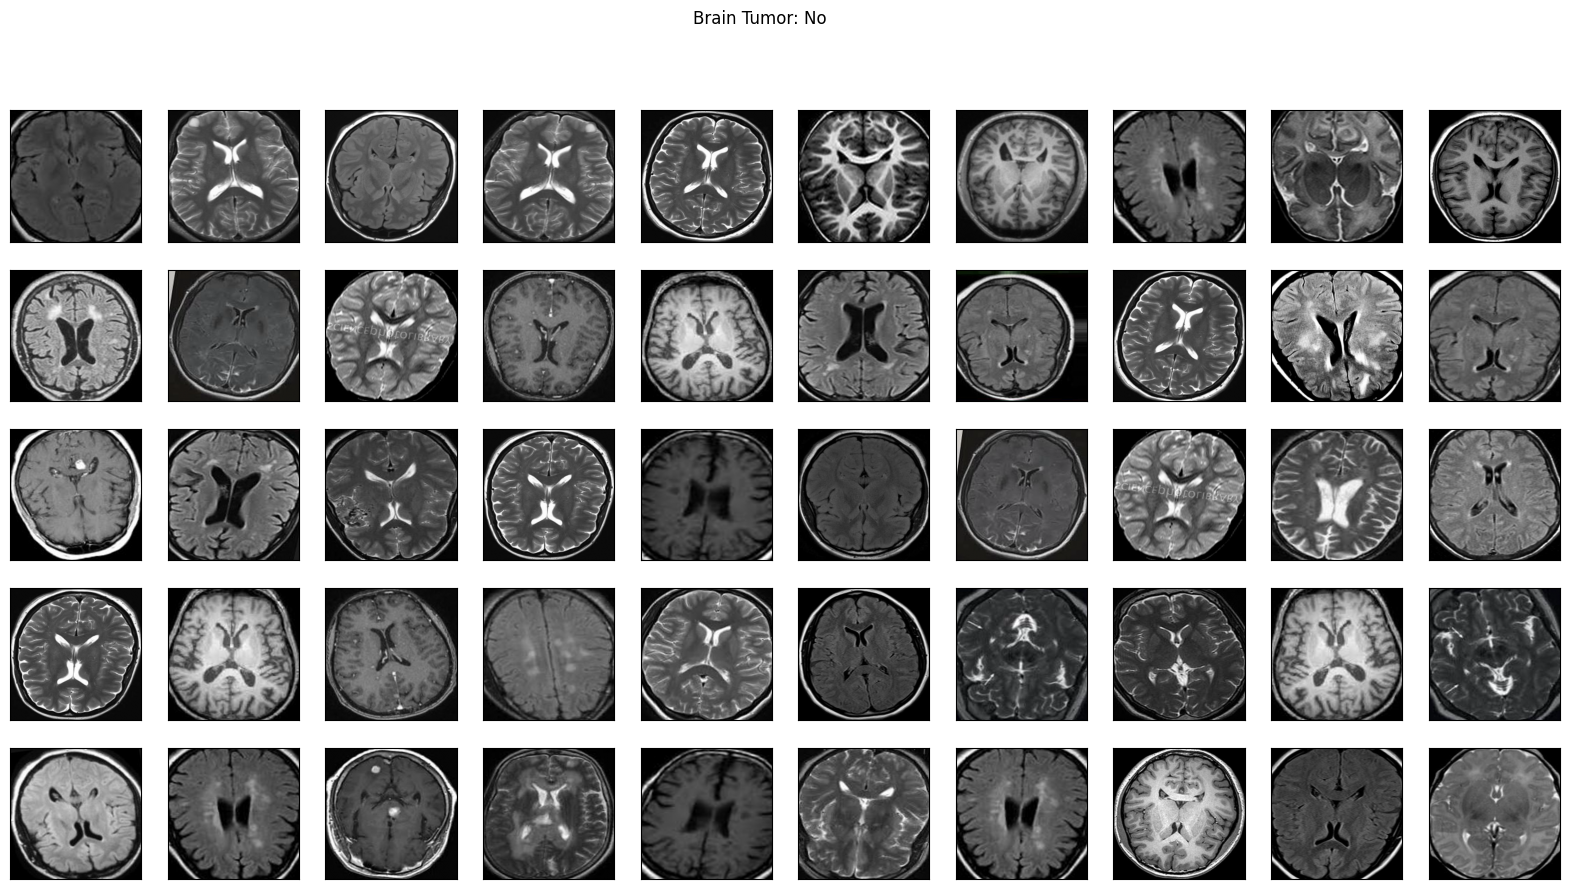

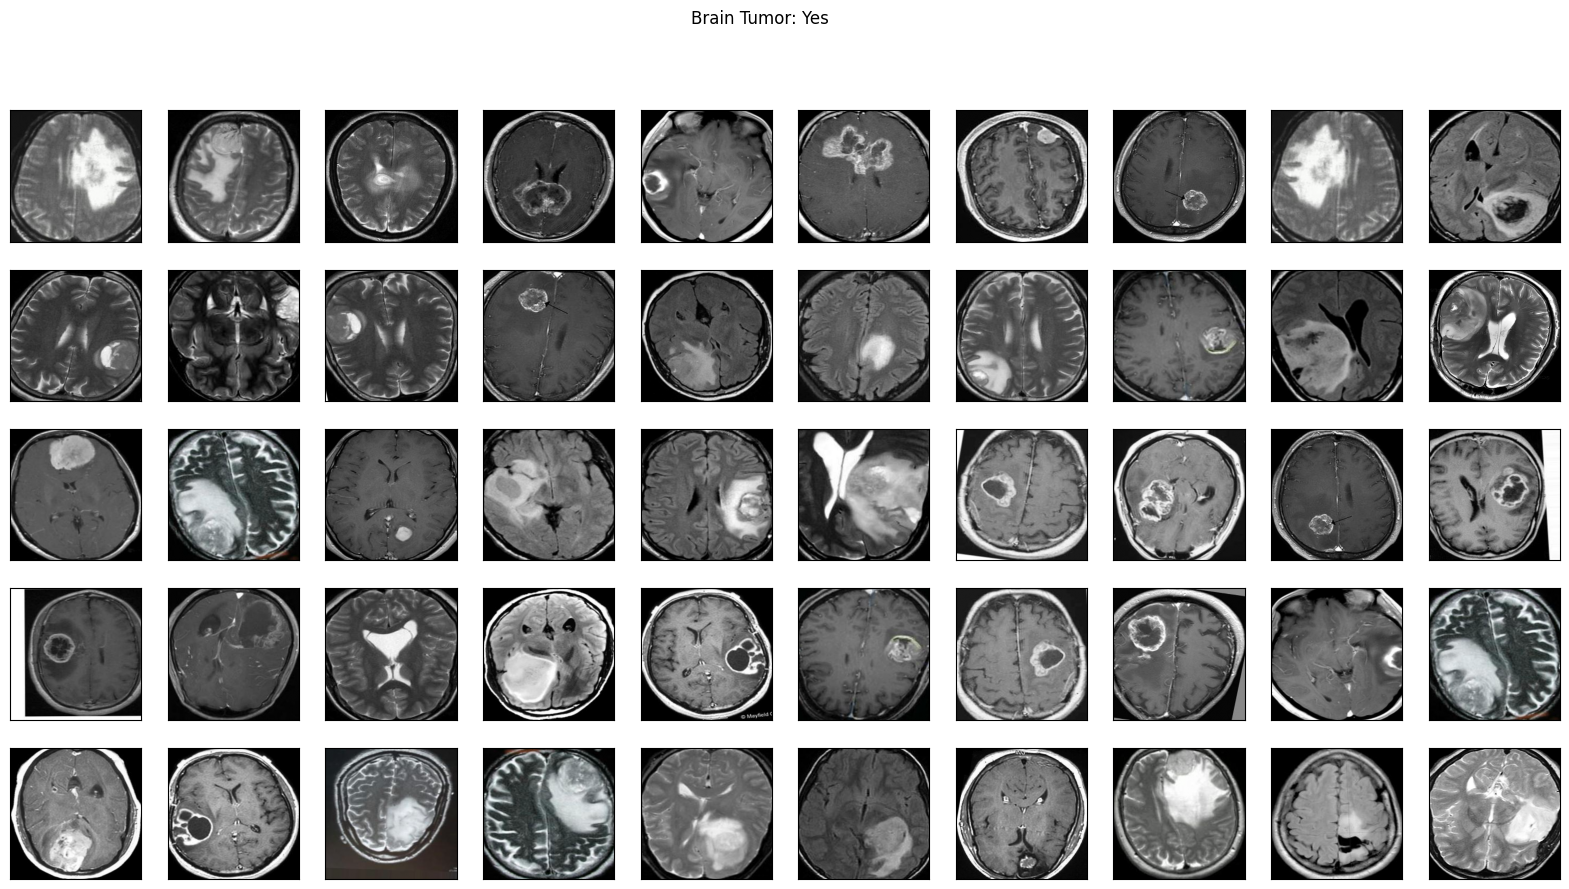

In [7]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [ ]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


## Helper Functions

In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

## Evaluation Functions

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, all_histories, experiment):
    colors = {
        'baseline': 'blue',    # Baseline model
        2: 'gray',            
        3: 'red',
        4: 'purple',
        5: 'orange',
        6: 'brown',
        7: 'pink',
        8: 'green'               
    }

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

    # Loss Plot (Left)
    axes[0].plot(history['loss'], label='Train Loss (Baseline)', color=colors['baseline'])
    axes[0].plot(history['val_loss'], label='Val Loss (Baseline)', linestyle='--', color=colors['baseline'])
    for value, hist in all_histories.items():
        axes[0].plot(hist['loss'], label=f'Train Loss ({experiment} {value})', color=colors[value])
        axes[0].plot(hist['val_loss'], label=f'Val Loss ({experiment} {value})', linestyle='--', color=colors[value])
    axes[0].set_title(f'Loss Comparison Across {experiment} Models')
    axes[0].legend()

    # Accuracy Plot (Right)
    axes[1].plot(history['accuracy'], label='Train Acc (Baseline)', color=colors['baseline'])
    axes[1].plot(history['val_accuracy'], label='Val Acc (Baseline)', linestyle='--', color=colors['baseline'])
    for value, hist in all_histories.items():
        axes[1].plot(hist['accuracy'], label=f'Train Acc ({experiment} {value})', color=colors[value])
        axes[1].plot(hist['val_accuracy'], label=f'Val Acc ({experiment} {value})', linestyle='--', color=colors[value])
    axes[1].set_title(f'Accuracy Comparison Across {experiment} Models')
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()  
    plt.show()

In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [ ]:
def evaluate(model):
    model.metrics_names
    loss, acc = model.evaluate(x=X_test, y=y_test)

    y_val_prob = model.predict(X_val)
    f1score_val = compute_f1_score(y_val, y_val_prob)

    y_test_prob = model.predict(X_test)
    f1score = compute_f1_score(y_test, y_test_prob)

    print (f"Test Loss = {loss}")
    print (f"Test Accuracy = {acc}")
    print(f"Val F1 Score: {f1score_val}")
    print(f"Test F1 Score: {f1score}")

    return acc

# Build the default model

Let's build a convolutional neural network model:

<img src='../convnet_architecture.jpg'>

In [15]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [17]:
model = build_model(IMG_SHAPE)
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

# Compile and train the model:

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create a directory specific to each layer depth
model_dir = f"models"
os.makedirs(model_dir, exist_ok=True)

start_time = time.time()

# Train the model without checkpointing
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Baseline model - Elapsed time: {hms_string(execution_time)}")

# Save the model after training is complete
model_file = f"{model_dir}/baseline.keras"
model.save(model_file)

history = model.history.history
for key in history.keys():
    print(key)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6057 - loss: 0.9352 - val_accuracy: 0.5548 - val_loss: 0.6521
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7928 - loss: 0.4408 - val_accuracy: 0.7581 - val_loss: 0.5873
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7483 - loss: 0.5438 - val_accuracy: 0.4774 - val_loss: 0.8045
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7467 - loss: 0.5093 - val_accuracy: 0.7419 - val_loss: 0.5245
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8818 - loss: 0.2975 - val_accuracy: 0.7000 - val_loss: 0.5476
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8757 - loss: 0.3175 - val_accuracy: 0.6710 - val_loss: 0.6051
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8944 - loss: 0.2630 - val_accuracy: 0.7871 - val_loss: 0.4602
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9126 - loss: 0.2469 - val_accuracy: 0.7387 - val_loss:

# Experiment 1: Layer Depth

We will experiment with the depth of the model by adding more convolutional layers. Specifically, we will test 1, 5 and 8 convolutional layers. We will keep a Batch Normalisation and ReLU activation function block after each convolutional layer to be consistent with the baseline model.

In [19]:
def build_model_exp_1(input_shape, layer_depth):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    for i in range(layer_depth):
        # CONV -> BN -> RELU Block applied to X
        X = Conv2D(32, (7, 7), strides = (1, 1), name = f'conv{i}')(X)
        X = BatchNormalization(axis = 3, name = f'bn{i}')(X)
        X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name=f'BrainDetectionModel_depth_{layer_depth}')
    
    return model

## Experiment 1: Build and train the models  

For each layer depth defined in the experiment, we build and train a model keeping all other architecture hyperparameters the same as the baseline model.

In [ ]:
layer_depths = [5, 8]
histories = {}

for depth in layer_depths:
    model = build_model_exp_1(IMG_SHAPE, layer_depth=depth)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create a directory specific to each layer depth
    model_dir = f"models/exp1"
    os.makedirs(model_dir, exist_ok=True)

    start_time = time.time()

    # Train the model without checkpointing
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True)

    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"Depth {depth} - Elapsed time: {hms_string(execution_time)}")

    # Save the model after training is complete
    model_file = f"{model_dir}/depth-{depth}.keras"
    model.save(model_file)

    # Store the history for this depth
    histories[depth] = model.history.history
    print(f"History keys for depth {depth}: {list(model.history.history.keys())}")

Model: "BrainDetectionModel_depth_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 232, 232, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 232, 232, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 232, 232, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 226, 226, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 226, 226, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 226, 226, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 220, 220, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 220, 220, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 220, 220, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 214, 214, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 214, 214, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 214, 214, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         5,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,617 (826.63 KB)

 Trainable params: 211,297 (825.38 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 487s 10s/step - accuracy: 0.5584 - loss: 1.1666 - val_accuracy: 0.5581 - val_loss: 1.4985
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 479s 10s/step - accuracy: 0.7761 - loss: 0.4911 - val_accuracy: 0.5516 - val_loss: 0.9416
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 474s 10s/step - accuracy: 0.7581 - loss: 0.4848 - val_accuracy: 0.5871 - val_loss: 0.7888
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 474s 10s/step - accuracy: 0.8634 - loss: 0.3454 - val_accuracy: 0.5613 - val_loss: 1.1753
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 475s 10s/step - accuracy: 0.8754 - loss: 0.3036 - val_accuracy: 0.7097 - val_loss: 0.5808
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 473s 10s/step - accuracy: 0.9140 - loss: 0.2348 - val_accuracy: 0.7516 - val_loss: 0.5104
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 475s 10s/step - accuracy: 0.9077 - loss: 0.2303 - val_accuracy: 0.7871 - val_loss: 0.4747
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1634s 36s/step - accuracy: 0.9350 - loss: 0.1788 - val_accuracy: 0

Model: "BrainDetectionModel_depth_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 232, 232, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 232, 232, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 232, 232, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 226, 226, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 226, 226, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 226, 226, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 220, 220, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 220, 220, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 220, 220, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 214, 214, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 214, 214, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 214, 214, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 208, 208, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 208, 208, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 208, 208, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 202, 202, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 202, 202, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 202, 202, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 196, 196, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 361,825 (1.38 MB)

 Trainable params: 361,313 (1.38 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 807s 17s/step - accuracy: 0.6218 - loss: 0.9667 - val_accuracy: 0.5323 - val_loss: 2.8342
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 743s 16s/step - accuracy: 0.7910 - loss: 0.4649 - val_accuracy: 0.5387 - val_loss: 1.4111
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 745s 16s/step - accuracy: 0.8427 - loss: 0.3684 - val_accuracy: 0.5387 - val_loss: 2.3391
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 737s 16s/step - accuracy: 0.8562 - loss: 0.3329 - val_accuracy: 0.5355 - val_loss: 3.0283
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 734s 16s/step - accuracy: 0.8549 - loss: 0.3133 - val_accuracy: 0.6129 - val_loss: 1.6177
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 739s 16s/step - accuracy: 0.8978 - loss: 0.2474 - val_accuracy: 0.5419 - val_loss: 2.4832
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 733s 16s/step - accuracy: 0.8951 - loss: 0.2794 - val_accuracy: 0.5935 - val_loss: 2.0741
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 741s 16s/step - accuracy: 0.9153 - loss: 0.2095 - val_accuracy: 0.

## Experiment 1: Plot Metrics for Training and Validation Sets

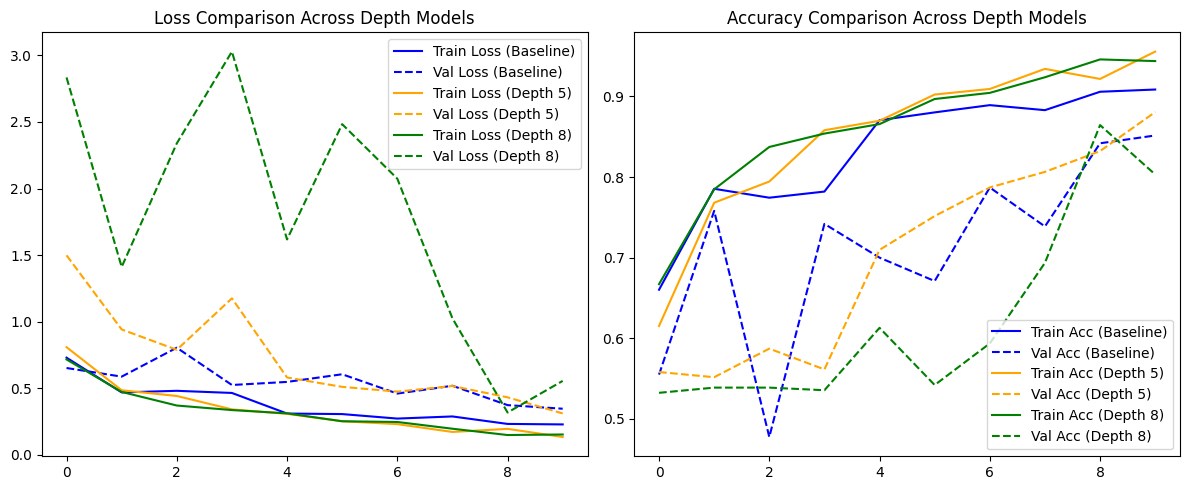

In [21]:
plot_metrics(history, histories, experiment='Depth')

## Experiment 1: Evaluation on Test Set

In [ ]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

depth_models_dir = 'models/exp1'
depth_models_paths = [f for f in listdir(depth_models_dir) if f.endswith('.keras')]
for path in depth_models_paths:
    depth = str(path.split('-')[1].split('.')[0])
    model = load_model(f"{depth_models_dir}/{path}")
    models['Depth '+depth] = model

# Save the best layer depth according to the accuracy of different models
best_layer_depth = 1
best_accuracy_layer_depth = 0

for name, model in models.items():
    print(f"----------------- Evaluating {name} -----------------")
    acc = evaluate(model)
    if acc > best_accuracy_layer_depth:
        best_accuracy_layer_depth = acc
        best_layer_depth = int(name.split(' ')[-1])

----------------- Evaluating Baseline -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8849 - loss: 0.3088
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step
Test Loss = 0.31432047486305237
Test Accuracy = 0.8870967626571655
Val F1 Score: 0.8597560975609756
Test F1 Score: 0.8881789137380192
----------------- Evaluating Depth 5 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8621 - loss: 0.2948
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
Test Loss = 0.2677743434906006
Test Accuracy = 0.8870967626571655
Val F1 Score: 0.892128279883382
Test F1 Score: 0.8967551622418879
----------------- Evaluating Depth 8 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8017 - loss: 0.5252
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step
Test Loss = 0.5347605347633362
Test Accuracy = 0.7967742085456848
Val F1 Score: 0.8328767123287671
Test F1 Sc

# Experiment 2: Kernel Size

For the second experiment we will be modifying the size of the kernel filter used in convolutions. We will test 3x3, 5x5 and 7x7 kernel sizes. The 3x3 and 5x5 sizes are inspired on the literature. The 7x7 size is taken from the original baseline model for comparison.

Stride is kept constant at (1, 1) to be consistent with the baseline model and because it is common in the literature.

In [23]:
def build_model_exp_2(input_shape, kernel_size):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (kernel_size, kernel_size), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name=f'BrainDetectionModel_kernel_size_{kernel_size}')
    
    return model

## Experiment 2: Build and train the models  

For each kernel size defined in the experiment, we build and train a model keeping all other architecture hyperparameters the same as the baseline model.

In [ ]:
kernel_sizes = [3, 5]
histories = {}

for kernel_size in kernel_sizes:
    model = build_model_exp_2(IMG_SHAPE, kernel_size=kernel_size)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create a directory for this experiment
    model_dir = f"models/exp2"
    os.makedirs(model_dir, exist_ok=True)

    start_time = time.time()

    # Train the model without checkpointing
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True)

    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"kernel Size {kernel_size} - Elapsed time: {hms_string(execution_time)}")

    # Save the model after training is complete
    model_file = f"{model_dir}/kernel_size-{kernel_size}.keras"
    model.save(model_file)

    # Store the history for this kernel size
    histories[kernel_size] = model.history.history
    print(f"History keys for kernel size {kernel_size}: {list(model.history.history.keys())}")

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5279 - loss: 1.4590 - val_accuracy: 0.7000 - val_loss: 0.6610
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7015 - loss: 0.5481 - val_accuracy: 0.4839 - val_loss: 0.6859
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6953 - loss: 0.6519 - val_accuracy: 0.7065 - val_loss: 0.6227
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8299 - loss: 0.3869 - val_accuracy: 0.4935 - val_loss: 0.6963
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8473 - loss: 0.3715 - val_accuracy: 0.5419 - val_loss: 0.6622
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8657 - loss: 0.3461 - val_accuracy: 0.5065 - val_loss: 0.7607
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8770 - loss: 0.2795 - val_accuracy: 0.5839 - val_loss: 0.6546
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8832 - loss: 0.2961 - val_accuracy: 0.7355 - val_loss:

## Experiment 2: Plot Metrics for Training and Validation Sets

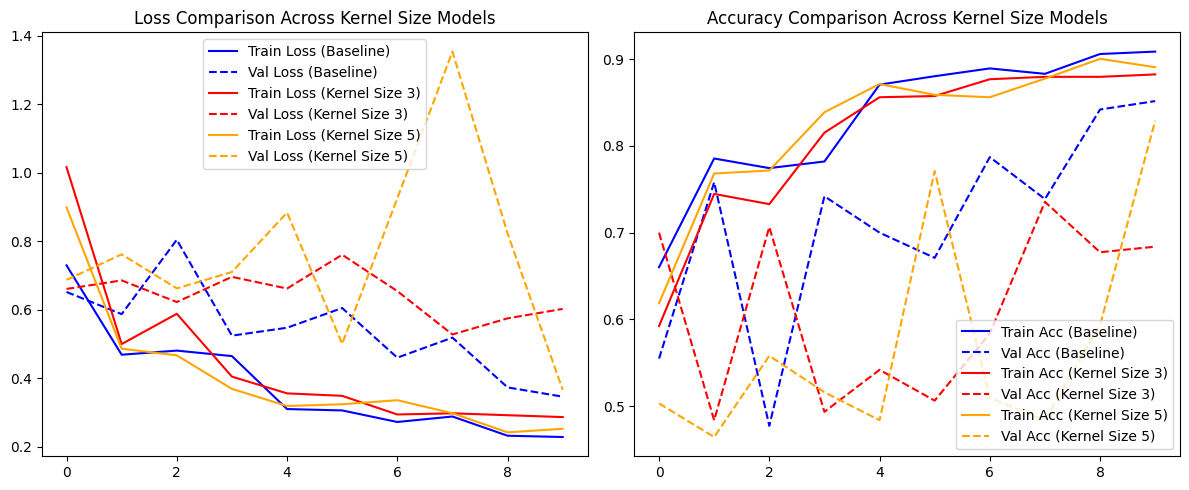

In [25]:
plot_metrics(history, histories, experiment='Kernel Size')

## Experiment 2: Evaluation on Test Set

In [ ]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

kernel_size_models_dir = 'models/exp2'
kernel_size_models_paths = [f for f in listdir(kernel_size_models_dir) if f.endswith('.keras')]
for path in kernel_size_models_paths:
    kernel_size = str(path.split('-')[1].split('.')[0])
    model = load_model(f"{kernel_size_models_dir}/{path}")
    models['Kernel Size '+kernel_size] = model

# Save the best kernel size according to the accuracy of different models
best_kernel_size = 7
best_accuracy_kernel_size = 0

for name, model in models.items():
    print(f"----------------- Evaluating {name} -----------------")
    acc = evaluate(model)
    if acc > best_accuracy_kernel_size:
        best_accuracy_kernel_size = acc
        best_kernel_size = int(name.split(' ')[-1])

----------------- Evaluating Baseline -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.8849 - loss: 0.3088
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
Test Loss = 0.31432047486305237
Test Accuracy = 0.8870967626571655
Val F1 Score: 0.8597560975609756
Test F1 Score: 0.8881789137380192
----------------- Evaluating Kernel Size 3 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6798 - loss: 0.6144
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step
Test Loss = 0.5797852873802185
Test Accuracy = 0.7064515948295593
Val F1 Score: 0.6016260162601627
Test F1 Score: 0.6192468619246861
----------------- Evaluating Kernel Size 5 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8813 - loss: 0.3121
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Test Loss = 0.31780824065208435
Test Accuracy = 0.8709677457809448
Val F1 Score: 0.8

# Experiment 3: Dropout Rate

In this third experiment we will be seeing how different dropout rates affect model performance when identifying the presence of a brain tumor. We will test the baseline model with no dropout and compare it to adding a dropout layer of 0.1 and 0.3. 

In [ ]:
def build_model_exp_3(input_shape, dropout_rate):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)

    # DROPOUT
    X = Dropout(dropout_rate, name='dropout0')(X)

    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name=f'BrainDetectionModel_dropout_rate_{dropout_rate}')
    
    return model

## Experiment 3: Build and train the models  

For each dropout rate defined in the experiment, we build and train a model. We will keep all other architecture hyperparameters the same as the baseline model as a control. 

In [ ]:
dropout_rates = [0.1, 0.3]
histories = {}

for dropout_rate in dropout_rates:
    model = build_model_exp_3(IMG_SHAPE, dropout_rate=dropout_rate)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create a directory for this experiment
    model_dir = f"models/exp3"
    os.makedirs(model_dir, exist_ok=True)

    start_time = time.time()

    # Train the model without checkpointing
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True)

    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"Dropout Rate {dropout_rate} - Elapsed time: {hms_string(execution_time)}")

    # Save the model after training is complete
    model_file = f"{model_dir}/dropout_rate-{dropout_rate}.keras"
    model.save(model_file)

    # Store the history for this dropout rate
    histories[dropout_rate] = model.history.history
    print(f"History keys for dropout rate {dropout_rate}: {list(model.history.history.keys())}")

## Experiment 3: Plot Metrics for Training and Validation Sets

In [ ]:
plot_metrics(history, histories, experiment='Dropout Rate')

## Experiment 3: Evaluation on Test Set

In [ ]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

dropout_rates_models_dir = 'models/exp3'
dropout_rates_models_paths = [f for f in listdir(dropout_rates_models_dir) if f.endswith('.keras')]
for path in dropout_rates_models_paths:
    dropout_rate = str(path.split('-')[1].split('.')[0])
    model = load_model(f"{dropout_rates_models_dir}/{path}")
    models['Dropout Rate '+dropout_rate] = model

# Save the best dropout rate according to the accuracy of different models
best_dropout_rate = 0
best_accuracy_dropout_rate = 0

for name, model in models.items():
    print(f"----------------- Evaluating {name} -----------------")
    acc = evaluate(model)
    if acc > best_accuracy_dropout_rate:
        best_accuracy_dropout_rate = acc
        best_dropout_rate = int(name.split(' ')[1])

# Build Best Model

Following the experiments we conducted to find the best independent architecture choices, we will combine the best performing ones into a single model and compare this new model's performance to the baseline model and the models from the experiments.

In [ ]:
def build_best_model(input_shape, layer_depth, kernel_size, dropout_rate):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    for i in range(layer_depth):
        # CONV -> BN -> RELU Block applied to X
        X = Conv2D(32, (kernel_size, kernel_size), strides = (1, 1), name = f'conv{i}')(X)
        X = BatchNormalization(axis = 3, name = f'bn{i}')(X)
        X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)

    # DROPOUT
    X = Dropout(dropout_rate, name='dropout0')(X)

    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name=f'BrainDetectionModel_layer_depth_{layer_depth}_kernel_size_{kernel_size}_dropout_rate_{dropout_rate}')
    
    return model

In [ ]:
# Take the best performing hyperparameters from the controlled experiments 
layer_depth = best_layer_depth
kernel_size = best_kernel_size
dropout_rate = best_dropout_rate

model = build_best_model(IMG_SHAPE, layer_depth=layer_depth, kernel_size=kernel_size, dropout_rate=dropout_rate)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create a directory for this experiment
model_dir = f"models"
os.makedirs(model_dir, exist_ok=True)

start_time = time.time()

# Train the model without checkpointing
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Dropout Rate {dropout_rate} - Elapsed time: {hms_string(execution_time)}")

# Save the model after training is complete
model_file = f"{model_dir}/best_model_layer_depth-{layer_depth}_kernel_size-{kernel_size}_dropout_rate-{dropout_rate}.keras"
model.save(model_file)

# Store the history for this dropout rate
history_best_model = model.history.history
print(f"History keys for best model: {list(model.history.history.keys())}")

## Plot metrics for training and validation sets for baseline and best models

In [ ]:
plot_metrics(history, {'Best Model': history_best_model}, experiment='Baseline and Best')

## Evaluation on Test Set


In [ ]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

best_path = 'models/best.keras'
model = load_model(best_path)
models['Best'] = model

for name, model in models.items():
    print(f"----------------- Evaluating {name} -----------------")
    evaluate(model)

### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [27]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [28]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [29]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.17993079584775%, number of pos examples: 754
Percentage of negative examples: 47.82006920415225%, number of neg examples: 691
Validation Data:
Number of examples: 310
Percentage of positive examples: 53.87096774193548%, number of pos examples: 167
Percentage of negative examples: 46.12903225806452%, number of neg examples: 143
Testing Data:
Number of examples: 310
Percentage of positive examples: 52.903225806451616%, number of pos examples: 164
Percentage of negative examples: 47.096774193548384%, number of neg examples: 146


As expected, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

Hooray!

How to do checkpoints

In [30]:
# kernel_sizes = [3, 5]
# histories = {}

# for kernel_size in kernel_sizes:
#     model = build_model(IMG_SHAPE, layer_depth=depth)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     # checkpoint
#     # Create a directory specific to each layer depth
#     model_dir = f"exp2_{kernel_size}"
#     os.makedirs(model_dir, exist_ok=True)

#     # Define file path to include depth and validation accuracy
#     filepath = os.path.join(model_dir, "cnn-parameters-improvement--{epoch:02d}-{val_accuracy:.2f}.keras")
#     # save the model with the best validation (development) accuracy till now
#     checkpoint = ModelCheckpoint("models/{}.keras".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

#     start_time = time.time()

#     model.fit(x=X_train, y=y_train, batch_size=32, epochs=2, validation_data=(X_val, y_val), callbacks=[checkpoint])

#     end_time = time.time()
#     execution_time = (end_time - start_time)
#     print(f"Elapsed time: {hms_string(execution_time)}")

#     # Store the history for this kernel size
#     histories[kernel_size] = model.history.history
#     print(f"History keys for kernel size {kernel_size}: {list(model.history.history.keys())}")
